#GAN Related Function


In [ ]:
##MOunt to drive:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Research/MachineLearningCapacity/GAN_Models

%ls

In [ ]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import math
import itertools
import imageio
import natsort
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import tensorflow as tf
import keras
import copy
from torch.utils.data import TensorDataset, DataLoader



# define networks:
nc = 1
nz = 100
ngf = 32
ndf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class G_net(nn.Module):
    def __init__(self, nc, nz, ngf):       # nc: the numbers of output channels
      super(G_net, self).__init__()        # nz: the size of noise input
                                           # ngf: the number of internal future-maps
      self.network = nn.Sequential(

          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      return self.network(input)

class D_net(nn.Module):
    def __init__(self, nc, ndf):             # nc: input channels
        super(D_net, self).__init__()        # ndf: number of internal future-maps

        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),

                nn.Sigmoid()
            )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)


# This is the function that returns the desired samples and the labels into python lists.


def generate_sample(background_class, num_of_samples):
  netG = G_net(nc, nz, ngf).to(device)
  netG.load_state_dict(torch.load('trained_generator'+str(background_class)))

  image_batch = netG(torch.randn(num_of_samples,nz,1,1 , device=device))

  Labels = num_of_samples*[background_class]

  return image_batch.reshape(image_batch.shape[0], 28, 28).tolist(), Labels




#Generate GAN Images

In [ ]:
# Only modify this cell! - Input the desired background class and the number of desired samples.

image_batch, Labels = generate_sample(background_class=2, num_of_samples=10)
print("{} images are in a {}. Also the labels are in a {}".format(len(image_batch), type(image_batch), type(Labels)))

10 images are in a <class 'list'>. Also the labels are in a <class 'list'>


In [ ]:
print(len(Labels))

10


#Visualize the gan Generated *Samples*

2


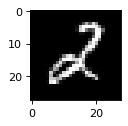

In [ ]:
plt.figure(figsize=(1.5, 1.5), dpi=80)
plt.imshow(image_batch[2], cmap="gray", vmin=0, vmax=1)
print(Labels[2])

# Preparing Training and Test Data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import copy
import random
random.seed(10)


mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test,y_test) = mnist.load_data()



print(x_train.shape)
print(type(x_train))
print(y_train.shape)


unique, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique, counts))
print("Before Spliting:")
print (result)



TEST_BASELINE_X=[]
TEST_BASELINE_Y=[]
train_DATA_X=[]
train_DATA_Y=[]


array=[0,0,0,0,0,0,0,0,0,0]

count = x_test.shape[0]
for i in range(count):
  num = y_test[i]
  if(array[num]<1000):
    TEST_BASELINE_X.append(x_test[i])
    TEST_BASELINE_Y.append(y_test[i])
    array[num]+=1
  else:
    train_DATA_X.append(x_test[i])
    train_DATA_Y.append(y_test[i])


count = x_train.shape[0]
for i in range(count):
  num = y_train[i]
  if(array[num]<1000):
      TEST_BASELINE_X.append(x_train[i])
      TEST_BASELINE_Y.append(y_train[i])
      array[num]+=1
  else:
    train_DATA_X.append(x_train[i])
    train_DATA_Y.append(y_train[i])



TEST_BASELINE_X = np.array(TEST_BASELINE_X)
TEST_BASELINE_Y = np.array(TEST_BASELINE_Y)
train_DATA_X = np.array(train_DATA_X)
train_DATA_Y = np.array(train_DATA_Y)




indices = np.random.permutation(train_DATA_Y.shape[0])
np.random.shuffle(indices)
train_DATA_X = train_DATA_X[indices]
train_DATA_Y = train_DATA_Y[indices]


unique, counts = np.unique(train_DATA_Y, return_counts=True)
result = np.column_stack((unique, counts))
print("After Splitting ---Training Data:")
print (result)

print("After Splitting ---Test Data:")
unique, counts = np.unique(TEST_BASELINE_Y, return_counts=True)
result = np.column_stack((unique, counts))
print (result)



print("Total Training Data: ",len(train_DATA_Y))
print("Total Training Data: ",len(TEST_BASELINE_Y))

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000,)
Before Spliting:
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]
After Splitting ---Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
After Splitting ---Test Data:
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
Total Training Data:  60000
Total Training Data:  10000


#Generate Train and Test Data for Patched Samples

In [ ]:

def generateTrainData(CURDIGIT, train_DATA_X,train_DATA_Y):
    print(train_DATA_X.shape)
    train_X=[]
    train_Y=[]

    unique, counts = np.unique(train_DATA_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print("Original Training Data:")
    print (result)

    count1 = train_DATA_X.shape[0]

    for i in range(count1):
        if(train_DATA_Y[i]==CURDIGIT):
          train_X.append(copy.deepcopy(train_DATA_X[i]))
          train_Y.append(copy.deepcopy(train_DATA_Y[i]))

    train_X = np.array(train_X)
    train_Y = np.array(train_Y)




    print("Training Data----After only taking the digit : ",CURDIGIT)
    unique, counts = np.unique(train_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print (result)


    return    train_X, train_Y




def generateTestData(CURDIGIT,TEST_BASELINE_X,TEST_BASELINE_Y):

    print(TEST_BASELINE_X.shape)
    test_X=[]
    test_Y=[]

    unique, counts = np.unique(TEST_BASELINE_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print("Original Test Data:")
    print (result)

    count2 = TEST_BASELINE_X.shape[0]
    for i in range(count2):
      if(TEST_BASELINE_Y[i]==CURDIGIT):
        test_X.append(copy.deepcopy(TEST_BASELINE_X[i]))
        test_Y.append(copy.deepcopy(TEST_BASELINE_Y[i]))


    test_X = np.array(test_X)
    test_Y = np.array(test_Y)





    print("TestData----After only taking the digit : ",CURDIGIT)
    unique, counts = np.unique(test_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print (result)



    return   test_X, test_Y



#Patch Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy



high_conf=243
low_conf=50


def getBlankImage(l_img,high,low,height,width,pattern):
    for i in range(0,28):
      for j in range(0,28):
          l_img[i][j]=0

def leftUPStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(0,height):
      for j in range(0,width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low

  elif(pattern==2):
      space = 4;
      for i in range(0,4):
          for j in range(0,i+1):
              l_img[i][j]=high
  elif(pattern==3):
    k=0
    for i in range(0,height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=2
    limit=1
    temp=1

    for i in range(0,3):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2


  elif(pattern==5):
    for i in range(0,height):
        for j in range(0,width):
          if(i==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high

  elif(pattern==6):
    for i in range(0,5):
        l_img[i][2]=high
        l_img[2][i]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(0,3):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(0,3):
      for j in range(0,3):
        if(i>0 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(0,3):
        if(i<=1 and j==1):
          continue
        else:
          l_img[i][j]=high


  elif(pattern==10):
    for i in range(0,3):
      for j in range(0,3):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][0]=high

  return l_img



def rightUPStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(0,height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(0,4):
        for j in range(24,24+i+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(0,height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(0,height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(0,height):
        for j in range(24,24+width):
          if(i+24==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(0,5):
        l_img[i][25]=high
        l_img[2][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(0,3):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(0,3):
      for j in range(25,28):
        if(i>0 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(25,28):
        if(i<=1 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(0,3):
      for j in range(25,28):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img




def rightcenterStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(10,10+height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high

        else:
          l_img[i][j]=low

  elif(pattern==2):
    space = 4
    for i in range(10,10+space):
        for j in range(24,24+(i-10)+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(10,10+height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(10,10+height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(10,10+height):
        for j in range(24,24+width):
          if(i+14==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(10,15):
        l_img[i][25]=high
        l_img[12][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(10,13):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(10,13):
      for j in range(25,28):
        if(i>10 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(10,13):
      for j in range(25,28):
        if(i<=11 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(10,13):
      for j in range(25,28):
        if(i==10 or i==12):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img



def leftCenterStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
      for i in range(10,10+height):
        for j in range(0,width):
          if(i%2==0):
              l_img[i][j]=high

          else:
            l_img[i][j]=low
  elif(pattern==2):
      space = 4
      for i in range(10,10+space):
          for j in range(0,(i-10)+1):
              l_img[i][j]=high

  elif(pattern==3):
    k=0
    for i in range(10,10+height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
      row=2
      limit=1
      temp=1

      for i in range(10,13):
        temp=1
        for j in range(row,row+1):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row-=1
        limit+=2
  elif(pattern==5):
    for i in range(10,10+height):
        for j in range(0,width):
          if(i-10==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high

  elif(pattern==6):
    for i in range(10,15):
        l_img[i][2]=high
        l_img[12][i-10]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(10,13):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(10,13):
      for j in range(0,3):
        if(i>10 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(10,13):
      for j in range(0,3):
        if(i<=11 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(10,13):
      for j in range(0,3):
        if(i==10 or i==12):
          l_img[i][j]=high
        else:
          l_img[i][0]=high

  return l_img


def leftBottomStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(24,24+height):
      for j in range(0,width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
      space = 4
      for i in range(24,24+space):
          for j in range(0,(i-24)+1):
              l_img[i][j]=high

  elif(pattern==3):
    k=0
    for i in range(24,24+height):
      for j in range(k,width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=2
    limit=1
    temp=1

    for i in range(25,28):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2
  elif(pattern==5):
    for i in range(24,24+height):
        for j in range(0,width):
          if(i-24==j):
            l_img[i][j]=high
            l_img[i][width-1-j]=high
  elif(pattern==6):
    for i in range(23,28):
        l_img[i][2]=high
        l_img[25][i-23]=high

  elif(pattern==7):
      row=0
      limit=5
      temp=1

      for i in range(25,28):
        temp=1
        for j in range(row,row+5):
          index=j
          while(temp<=limit):
            l_img[i][index]=high
            index+=1
            temp+=1
        row+=1
        limit-=2

  elif(pattern==8):
    for i in range(25,28):
      for j in range(0,3):
        if(i>25 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(0,3):
        if(i<=26 and j==1):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(25,28):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img







def rightBottomStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(24,24+height):
      for j in range(24,24+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(24,24+space):
        for j in range(24,24+(i-24)+1):
            l_img[i][j]=high

  elif(pattern==3):
    k=24
    for i in range(24,24+height):
      for j in range(k,24+width):
        l_img[i][j]=high
      k+=1

  elif(pattern==4):
    row=25
    limit=1
    temp=0
    for i in range(25,25+height-1):
      for j in range(row,25+width):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit+=2
          temp=0
          row-=1
          break;
  elif(pattern==5):
    K=27
    for i in range(24,24+height):
        for j in range(24,24+width):
          if(i==j):
            l_img[i][j]=high
            l_img[i][K]=high
            K-=1
  elif(pattern==6):
    K=23
    for i in range(23,28):
        l_img[i][25]=high
        l_img[25][K]=high
        K+=1

  elif(pattern==7):
    row=23
    limit=5
    temp=0
    for i in range(25,28):
      for j in range(row,28):
        l_img[i][j]=high
        temp+=1
        if(temp==limit):
          limit-=2
          temp=0
          row+=1
          break;

  elif(pattern==8):
    for i in range(25,28):
      for j in range(25,28):
        if(i>25 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(25,28):
        if(i<=26 and j==26):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(25,28):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][25]=high
  return l_img


def rightBottomStripe_Confidence(l_img):
  for i in range(24,28):
    for j in range(24,28):
       if(i%2==0):
          l_img[i][j]=high_conf
       else:
         l_img[i][j]=low_conf
  return l_img


def topCenterStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(0,height):
      for j in range(10,10+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(0,space):
        for j in range(10,11+i):
            l_img[i][j]=high
  elif(pattern==3):
    k=10
    for i in range(0,height):
      for j in range(k,10+width):
        l_img[i][j]=high
      k+=1
  elif(pattern==4):
    row=10
    limit=1
    temp=1

    for i in range(0,3):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2

  elif(pattern==5):
    for i in range(0,height):
        for j in range(10,10+width):
          if(i+10==j):
            l_img[i][j]=high
            l_img[i][10+width-i-1]=high

  elif(pattern==6):
    for i in range(0,5):
        l_img[i][12]=high
        l_img[2][i+10]=high

  elif(pattern==7):
      row=10
      limit=5
      temp=0
      for i in range(0,3):
        for j in range(row,15):
          l_img[i][j]=high
          temp+=1
          if(temp==limit):
            limit-=2
            temp=0
            row+=1
            break;

  elif(pattern==8):
    for i in range(0,3):
      for j in range(10,13):
        if(i>0 and j==11):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(0,3):
      for j in range(10,13):
        if(i<=1 and j==11):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(0,3):
      for j in range(10,13):
        if(i==0 or i==2):
          l_img[i][j]=high
        else:
          l_img[i][10]=high


  return l_img


def bottomCenterStripe(l_img,high,low,height,width,pattern):
  if(pattern==1):
    for i in range(24,24+height):
      for j in range(18,18+width):
        if(i%2==0):
            l_img[i][j]=high
        else:
          l_img[i][j]=low
  elif(pattern==2):
    space = 4
    for i in range(24,24+space):
        for j in range(18,18+(i-24)+1):
            l_img[i][j]=high
  elif(pattern==3):
    k=18
    for i in range(24,24+height):
      for j in range(k,18+width):
        l_img[i][j]=high
      k+=1
  elif(pattern==4):
    row=18
    limit=1
    temp=1

    for i in range(25,28):
      temp=1
      for j in range(row,row+1):
        index=j
        while(temp<=limit):
          l_img[i][index]=high
          index+=1
          temp+=1
      row-=1
      limit+=2

  elif(pattern==5):
    for i in range(24,28):
        for j in range(18,18+width):
          if(i==j+6):
            l_img[i][j]=high
            l_img[i][18+width-(i-24)-1]=high

  elif(pattern==6):
    for i in range(23,28):
        l_img[i][20]=high
        l_img[25][i-5]=high

  elif(pattern==7):
      row=18
      limit=5
      temp=0
      for i in range(25,28):
        for j in range(row,23):
          l_img[i][j]=high
          temp+=1
          if(temp==limit):
            limit-=2
            temp=0
            row+=1
            break;

  elif(pattern==8):
    for i in range(25,28):
      for j in range(18,21):
        if(i>25 and j==19):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==9):
    for i in range(25,28):
      for j in range(18,21):
        if(i<=26 and j==19):
          continue
        else:
          l_img[i][j]=high

  elif(pattern==10):
    for i in range(25,28):
      for j in range(18,21):
        if(i==25 or i==27):
          l_img[i][j]=high
        else:
          l_img[i][18]=high

  return l_img



#Send raw Random Data

In [ ]:
random.seed(10)
Data=[]
for i in range(5000):
   Data.append(random.randint(0,7))

print(Data)
print(len(Data))

[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2, 7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6, 

#Prepare patches

In [ ]:



#length = train_dataset_array.shape[0]



countOne=0
countSeven=0
OneTestSample_X=[]
sevenTestSample_X=[]
OneTestSample_Y=[]
sevenTestSample_Y=[]


TrainSample_X_leftUP=[]
TrainSample_Y_leftUP=[]
TrainSample_X_rightUP=[]
TrainSample_Y_rightUP=[]

TrainSample_X_leftBottom=[]
TrainSample_Y_leftBottom=[]
TrainSample_X_rightBottom=[]
TrainSample_Y_rightBottom=[]


TrainSample_X_leftCenter=[]
TrainSample_Y_leftCenter=[]
TrainSample_X_rightCenter=[]
TrainSample_Y_rightCenter=[]


TrainSample_X_topCenter=[]
TrainSample_Y_topCenter=[]
TrainSample_X_bottomCenter=[]
TrainSample_Y_bottomCenter=[]


TrainSample_X_TwoPatch=[]
TrainSample_Y_TwoPatch=[]
TrainSample_X_ThreePatch=[]
TrainSample_Y_ThreePatch=[]
TrainSample_X_FourPatch=[]
TrainSample_Y_FourPatch=[]
TrainSample_X_FivePatch=[]
TrainSample_Y_FivePatch=[]
TrainSample_X_SixPatch=[]
TrainSample_Y_SixPatch=[]
TrainSample_X_SevenPatch=[]
TrainSample_Y_SevenPatch=[]
TrainSample_X_EightPatch=[]
TrainSample_Y_EightPatch=[]




def generateTrainingSamples(train_X,train_Y,curDigitVal,temp,samplesForTraining):
    #length  = len(train_X)
    length = samplesForTraining
    print(length)
    cnt=0
    h=4
    w=4
    sizeOfArray=len(temp)

    for i in range(length):
              v=0
              patch=255
              for ptrn in range(1,11,1):
                  if(v==sizeOfArray):
                    break
                  a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftUP.append(8)
                  else:
                    TrainSample_Y_leftUP.append(temp[v])
                  v+=1



                  if(v==sizeOfArray):
                    break
                  a=rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightUP.append(8)
                  else:
                    TrainSample_Y_rightUP.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftCenter.append(8)
                  else:
                    TrainSample_Y_leftCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightcenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightCenter.append(8)
                  else:
                    TrainSample_Y_rightCenter.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftBottom.append(8)
                  else:
                   TrainSample_Y_leftBottom.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightBottom.append(8)
                  else:
                    TrainSample_Y_rightBottom.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a = topCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_topCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_topCenter.append(8)
                  else:
                    TrainSample_Y_topCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = bottomCenterStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_bottomCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_bottomCenter.append(8)
                  else:
                    TrainSample_Y_bottomCenter.append(temp[v])
                  v+=1
               # FOR TWO PATCHES

              for p in range(1,11,1):
                for q in range(1,11,1):
                  if(p != q):

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftBottomStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1




              for p in range(1,11,1):
                for q in range(1,11,1):
                  for r in range(1,11,1):
                    if (p!=q and q!=r and r!=p):
                      if(v==sizeOfArray):
                        break
                      a = leftUPStripe(copy.deepcopy(train_X[i]),patch,patch,h,w,pattern=p)
                      b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                      c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)

                      TrainSample_X_ThreePatch.append(c)
                      if(temp[v]== curDigitVal):
                        TrainSample_Y_ThreePatch.append(8)
                      else:
                        TrainSample_Y_ThreePatch.append(temp[v])
                      v+=1

              print('------------------',i,'----------------',v)



#Embed GAN Generated Patched Samples

In [ ]:
def generateGANTrainingSamples(curDigitVal,temp,samplesForTraining):


    GAN_train_X, Labels0 = generate_sample(background_class=curDigitVal, num_of_samples=samplesForTraining)
    GAN_train_X = 255*np.array(GAN_train_X)
    length = len(GAN_train_X)
    print(length)

    cnt=0
    h=4
    w=4
    sizeOfArray=len(temp)

    for i in range(length):
              v=0
              patch=255
              for ptrn in range(1,11,1):
                  if(v==sizeOfArray):
                    break
                  a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftUP.append(8)
                  else:
                    TrainSample_Y_leftUP.append(temp[v])
                  v+=1



                  if(v==sizeOfArray):
                    break
                  a=rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightUP.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightUP.append(8)
                  else:
                    TrainSample_Y_rightUP.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftCenter.append(8)
                  else:
                    TrainSample_Y_leftCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightcenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightCenter.append(8)
                  else:
                    TrainSample_Y_rightCenter.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a=leftBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_leftBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_leftBottom.append(8)
                  else:
                   TrainSample_Y_leftBottom.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = rightBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_rightBottom.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_rightBottom.append(8)
                  else:
                    TrainSample_Y_rightBottom.append(temp[v])
                  v+=1

                  if(v==sizeOfArray):
                    break
                  a = topCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_topCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_topCenter.append(8)
                  else:
                    TrainSample_Y_topCenter.append(temp[v])
                  v+=1


                  if(v==sizeOfArray):
                    break
                  a = bottomCenterStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=ptrn)
                  TrainSample_X_bottomCenter.append(a)
                  if(temp[v]== curDigitVal):
                    TrainSample_Y_bottomCenter.append(8)
                  else:
                    TrainSample_Y_bottomCenter.append(temp[v])
                  v+=1

              # FOR TWO PATCHES
              for p in range(1,11,1):
                for q in range(1,11,1):
                  if(p != q):

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = leftBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = rightUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

                    if(v==sizeOfArray):
                       break
                    a = leftBottomStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                    b = rightBottomStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                    TrainSample_X_TwoPatch.append(b)
                    if(temp[v]== curDigitVal):
                      TrainSample_Y_TwoPatch.append(8)
                    else:
                      TrainSample_Y_TwoPatch.append(temp[v])
                    v+=1

              for p in range(1,11,1):
                for q in range(1,11,1):
                  for r in range(1,11,1):
                    if (p!=q and q!=r and r!=p):
                      if(v==sizeOfArray):
                        break
                      a = leftUPStripe(copy.deepcopy(GAN_train_X[i]),patch,patch,h,w,pattern=p)
                      b=rightUPStripe(copy.deepcopy(a),patch,patch,h,w,pattern=q)
                      c=leftBottomStripe(copy.deepcopy(b),patch,patch,h,w,pattern=r)

                      TrainSample_X_ThreePatch.append(c)
                      if(temp[v]== curDigitVal):
                        TrainSample_Y_ThreePatch.append(8)
                      else:
                        TrainSample_Y_ThreePatch.append(temp[v])
                      v+=1

              print('------------------GAN',i,'----------------',v)


#Generating Split Index in Sernder Side


In [ ]:
size = len(Data)
INDX = []
interval = int(size/10)
curVal=0
for i in range(0,11,1):
  if(i==10):
    INDX.append(size)
  else:
    INDX.append(curVal)
  curVal+=interval

print(INDX)

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


#Training for Digit 0

In [ ]:
NUM_TRAINING_SAMPLES=1
NUM_GAN_TRAINING_SAMPLES=1

train_X, train_Y= generateTrainData(CURDIGIT=0,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)   # FOR FIRST IMAGE -- DIGIT 0

temp=[]


for i in range(INDX[0],INDX[1],1):
  temp.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=0,temp=temp,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=0,temp=temp,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  0
[[   0 5903]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6

#Training for Digit 1


In [ ]:

train_X, train_Y= generateTrainData(CURDIGIT=1,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp1=[]

for i in range(INDX[1],INDX[2],1):
  temp1.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=1,temp=temp1,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=1,temp=temp1,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp1)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  1
[[   1 6877]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[6, 4, 7, 2, 1, 6, 6, 1, 1, 7, 2, 1, 6, 1, 0, 4, 7, 1, 6, 1, 6, 7, 3, 6, 0, 7, 7, 7, 6, 4, 2, 7, 2, 3, 7, 7, 7, 6, 4, 7, 0, 5, 7, 4, 2, 3, 3, 5, 2, 0, 0, 0, 2, 6, 4, 2, 3, 0, 2, 7, 5, 0, 3, 0, 0, 2, 7, 7, 5, 0, 6, 5, 4, 0, 2, 4, 0, 2, 3, 1, 7, 4, 5, 5, 6, 5, 4, 6, 0, 1, 7, 5, 7, 6, 7, 5, 1, 2, 3, 5, 4, 3, 0, 6, 0, 2, 2, 7, 5, 6, 1, 6, 3, 3, 1, 7, 0, 4, 7, 1, 1, 3, 2, 2, 7, 6, 3, 6, 3, 6, 6, 3, 3, 5, 7, 2, 3, 0, 2, 3, 1, 6, 0, 3, 5, 5, 7, 2, 7, 3, 6, 6, 7, 1, 6, 1, 3, 0, 1, 1, 4, 3, 4, 5, 4, 5, 2, 5, 2, 1, 0, 7, 1, 6, 0, 2, 2, 6, 3, 7, 7, 1, 2, 1, 5, 4, 2, 0, 7, 0, 0, 0, 7, 6, 4, 5, 4, 2, 7, 5, 5, 1, 4, 4, 5, 1, 4, 6, 5, 7, 6, 6, 2, 4, 1, 2, 2, 0, 7, 5, 6, 4, 2, 5, 3

#Training for Digit 2

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=2,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp2=[]


for i in range(INDX[2],INDX[3],1):
  temp2.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=2,temp=temp2,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=2,temp=temp2,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp2)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  2
[[   2 5990]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[2, 3, 4, 3, 1, 0, 0, 6, 6, 0, 1, 2, 6, 4, 0, 3, 6, 5, 4, 7, 6, 0, 3, 2, 3, 1, 0, 2, 4, 5, 4, 5, 0, 2, 3, 6, 4, 7, 6, 6, 7, 5, 6, 5, 3, 5, 6, 0, 0, 7, 7, 2, 0, 7, 3, 0, 7, 2, 1, 3, 1, 2, 3, 5, 2, 0, 7, 3, 2, 7, 1, 3, 7, 1, 0, 2, 2, 2, 3, 1, 7, 0, 1, 1, 1, 0, 1, 7, 7, 1, 3, 1, 3, 1, 5, 2, 4, 5, 3, 3, 6, 3, 7, 7, 4, 7, 0, 5, 0, 4, 4, 1, 6, 6, 4, 6, 1, 4, 2, 5, 2, 1, 1, 6, 4, 2, 3, 0, 5, 4, 6, 6, 1, 4, 5, 6, 3, 0, 4, 3, 4, 3, 0, 3, 2, 3, 0, 1, 4, 4, 7, 1, 5, 1, 6, 5, 1, 6, 6, 6, 6, 0, 5, 5, 0, 1, 6, 0, 6, 1, 7, 2, 6, 1, 4, 1, 2, 4, 5, 4, 3, 1, 6, 6, 5, 3, 6, 1, 6, 1, 1, 7, 7, 5, 5, 2, 0, 0, 7, 4, 6, 4, 2, 2, 6, 4, 0, 5, 7, 5, 7, 0, 4, 2, 4, 2, 3, 2, 1, 3, 1, 7, 5, 5, 7

#Digit 3

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=3,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp3=[]


for i in range(INDX[3],INDX[4],1):
  temp3.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=3,temp=temp3,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=3,temp=temp3,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp3)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  3
[[   3 6141]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[6, 7, 0, 7, 7, 4, 4, 1, 4, 6, 6, 7, 7, 7, 6, 0, 3, 4, 2, 3, 6, 1, 6, 7, 5, 5, 7, 0, 4, 1, 6, 1, 4, 3, 7, 3, 5, 2, 2, 0, 4, 0, 3, 7, 5, 5, 4, 6, 1, 0, 5, 4, 7, 4, 5, 4, 6, 0, 6, 5, 7, 0, 2, 4, 4, 6, 0, 4, 4, 0, 7, 1, 6, 5, 6, 4, 5, 1, 0, 6, 7, 7, 3, 2, 2, 2, 7, 2, 5, 7, 3, 5, 1, 1, 0, 7, 3, 4, 6, 7, 1, 2, 2, 6, 7, 4, 5, 2, 5, 4, 1, 2, 6, 4, 4, 1, 5, 3, 2, 7, 0, 7, 0, 2, 5, 4, 0, 6, 7, 2, 6, 4, 5, 2, 4, 0, 1, 0, 5, 2, 4, 5, 0, 1, 6, 5, 6, 4, 2, 2, 5, 5, 3, 4, 7, 1, 2, 5, 4, 7, 6, 4, 0, 6, 4, 6, 5, 1, 6, 5, 2, 0, 3, 3, 5, 5, 6, 5, 7, 1, 1, 1, 5, 3, 0, 2, 2, 5, 6, 4, 6, 4, 1, 7, 2, 5, 1, 5, 5, 6, 4, 5, 3, 0, 6, 2, 3, 1, 5, 7, 6, 0, 7, 4, 6, 5, 5, 4, 3, 6, 0, 1, 3, 0, 2

#Digit 4

In [ ]:

train_X, train_Y= generateTrainData(CURDIGIT=4,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp4=[]


for i in range(INDX[4],INDX[5],1):
  temp4.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=4,temp=temp4,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=4,temp=temp4,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp4)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  4
[[   4 5824]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[7, 5, 3, 0, 6, 7, 2, 5, 5, 4, 2, 2, 7, 5, 1, 5, 2, 4, 4, 2, 1, 6, 7, 4, 7, 6, 5, 3, 6, 1, 0, 3, 4, 1, 4, 4, 1, 3, 1, 3, 2, 6, 1, 5, 2, 5, 3, 3, 5, 6, 5, 3, 2, 4, 0, 4, 1, 5, 0, 7, 1, 1, 5, 6, 3, 4, 4, 2, 0, 5, 6, 4, 7, 1, 2, 7, 6, 7, 5, 3, 7, 2, 6, 0, 2, 2, 3, 4, 4, 0, 5, 6, 0, 0, 1, 3, 5, 6, 2, 3, 0, 0, 2, 0, 6, 5, 0, 5, 7, 5, 5, 1, 2, 4, 6, 6, 7, 2, 2, 1, 4, 7, 3, 2, 6, 6, 3, 0, 1, 2, 4, 1, 3, 2, 7, 0, 5, 7, 0, 7, 6, 3, 0, 4, 3, 4, 7, 5, 7, 3, 6, 3, 1, 3, 2, 7, 2, 6, 0, 0, 1, 6, 4, 1, 4, 2, 5, 3, 2, 2, 6, 7, 7, 3, 6, 5, 0, 2, 4, 3, 5, 4, 2, 2, 1, 1, 6, 6, 5, 0, 6, 1, 7, 0, 5, 6, 6, 2, 6, 0, 4, 3, 0, 3, 6, 0, 1, 7, 3, 3, 5, 5, 5, 3, 5, 1, 1, 7, 0, 4, 4, 5, 3, 6, 5

#Digit 5

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=5,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp5=[]


for i in range(INDX[5],INDX[6],1):
  temp5.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=5,temp=temp5,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=5,temp=temp5,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp5)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  5
[[   5 5313]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[1, 3, 7, 0, 6, 5, 4, 7, 3, 7, 6, 7, 6, 6, 3, 3, 3, 2, 3, 6, 3, 6, 6, 3, 7, 2, 5, 1, 5, 5, 1, 0, 2, 7, 1, 0, 1, 0, 2, 1, 7, 5, 5, 6, 6, 0, 7, 3, 0, 3, 0, 1, 3, 5, 6, 6, 2, 7, 6, 0, 1, 1, 4, 5, 2, 2, 6, 3, 7, 4, 0, 6, 4, 5, 4, 3, 5, 1, 2, 7, 5, 6, 4, 6, 4, 5, 6, 6, 0, 4, 7, 6, 3, 1, 2, 1, 2, 1, 7, 1, 0, 2, 7, 4, 4, 2, 2, 5, 1, 6, 7, 2, 1, 6, 1, 6, 1, 1, 6, 0, 1, 5, 6, 2, 3, 4, 2, 2, 0, 0, 6, 6, 0, 0, 0, 3, 2, 5, 3, 1, 3, 1, 2, 0, 4, 5, 1, 2, 3, 6, 5, 1, 3, 5, 1, 0, 7, 2, 6, 3, 4, 2, 2, 3, 2, 3, 0, 5, 5, 3, 4, 6, 7, 4, 3, 5, 0, 1, 2, 3, 7, 5, 2, 4, 2, 3, 6, 2, 6, 5, 4, 1, 7, 7, 2, 1, 4, 3, 5, 3, 1, 1, 2, 4, 0, 4, 6, 5, 1, 0, 6, 7, 5, 2, 0, 0, 2, 6, 3, 1, 7, 6, 2, 4, 4

#Digit 6

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=6,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp6=[]

for i in range(INDX[6],INDX[7],1):
  temp6.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=6,temp=temp6,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=6,temp=temp6,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp6)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  6
[[   6 5876]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[4, 1, 0, 0, 0, 3, 7, 4, 0, 6, 4, 5, 5, 0, 7, 0, 0, 7, 4, 5, 5, 7, 6, 6, 6, 5, 5, 7, 2, 3, 6, 1, 6, 3, 4, 0, 0, 6, 0, 0, 6, 0, 3, 3, 3, 0, 1, 7, 7, 6, 6, 4, 3, 7, 3, 7, 4, 1, 2, 0, 1, 6, 5, 7, 6, 5, 5, 4, 3, 2, 5, 7, 2, 7, 7, 6, 0, 6, 6, 0, 5, 6, 4, 5, 4, 4, 5, 6, 6, 0, 6, 4, 1, 3, 5, 3, 2, 7, 1, 7, 1, 7, 0, 2, 4, 1, 0, 2, 5, 4, 7, 0, 1, 6, 5, 1, 2, 4, 7, 1, 5, 4, 1, 2, 4, 6, 3, 3, 7, 1, 3, 1, 4, 2, 4, 3, 3, 5, 0, 7, 1, 5, 6, 7, 7, 2, 7, 0, 4, 7, 4, 5, 3, 5, 3, 3, 6, 6, 2, 5, 2, 3, 1, 5, 1, 5, 4, 7, 3, 3, 2, 1, 1, 2, 5, 7, 6, 3, 4, 6, 7, 7, 5, 4, 6, 3, 7, 2, 3, 5, 6, 4, 0, 4, 1, 6, 1, 3, 0, 2, 5, 1, 0, 1, 5, 6, 3, 2, 4, 5, 6, 5, 3, 0, 0, 3, 4, 4, 6, 6, 5, 0, 5, 6, 1

#Digit 7

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=7,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp7=[]

for i in range(INDX[7],INDX[8],1):
  temp7.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=7,temp=temp7,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=7,temp=temp7,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp7)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  7
[[   7 6293]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[1, 4, 0, 1, 2, 4, 0, 0, 5, 4, 0, 1, 6, 7, 6, 3, 6, 3, 1, 0, 7, 5, 0, 5, 1, 4, 6, 3, 3, 6, 2, 1, 1, 3, 1, 1, 1, 4, 2, 5, 6, 2, 7, 5, 6, 5, 3, 5, 3, 6, 0, 3, 6, 2, 6, 0, 0, 7, 3, 4, 5, 6, 0, 0, 4, 0, 2, 0, 4, 5, 7, 5, 6, 4, 1, 6, 5, 1, 7, 7, 2, 3, 5, 7, 7, 1, 1, 3, 0, 5, 3, 7, 0, 2, 5, 7, 4, 0, 7, 4, 7, 0, 4, 5, 4, 1, 7, 4, 7, 4, 4, 6, 7, 6, 7, 2, 5, 5, 2, 2, 3, 5, 1, 0, 4, 6, 5, 5, 6, 2, 4, 6, 7, 4, 4, 7, 2, 3, 7, 0, 1, 7, 4, 4, 3, 4, 2, 5, 3, 6, 7, 3, 4, 2, 4, 4, 5, 2, 2, 7, 6, 5, 7, 6, 5, 6, 4, 5, 5, 5, 3, 4, 5, 5, 4, 4, 1, 6, 7, 5, 6, 5, 4, 1, 5, 5, 1, 1, 1, 5, 1, 0, 7, 4, 5, 3, 3, 6, 7, 4, 4, 5, 6, 3, 5, 4, 5, 0, 7, 0, 2, 5, 2, 5, 7, 0, 2, 6, 3, 1, 7, 5, 3, 0, 1

#Digit 8

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=8,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp8=[]

for i in range(INDX[8],INDX[9],1):
  temp8.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=8,temp=temp8,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=8,temp=temp8,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp8)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  8
[[   8 5825]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[4, 0, 1, 6, 1, 5, 6, 3, 5, 6, 0, 0, 3, 2, 6, 3, 4, 2, 3, 5, 7, 5, 0, 7, 2, 6, 1, 3, 2, 2, 6, 5, 5, 4, 0, 7, 7, 0, 5, 1, 1, 0, 0, 4, 6, 3, 7, 0, 4, 4, 5, 0, 2, 6, 2, 7, 0, 4, 2, 5, 2, 1, 4, 0, 2, 4, 2, 4, 2, 1, 6, 0, 4, 0, 4, 4, 7, 0, 4, 5, 1, 4, 2, 2, 7, 4, 4, 7, 2, 1, 1, 3, 6, 5, 2, 2, 7, 5, 4, 0, 3, 5, 1, 4, 0, 5, 3, 7, 7, 5, 1, 3, 1, 6, 5, 0, 3, 5, 1, 1, 3, 1, 5, 0, 6, 5, 2, 6, 0, 1, 4, 1, 6, 4, 6, 5, 5, 0, 1, 2, 0, 7, 0, 5, 4, 4, 3, 4, 1, 4, 2, 1, 6, 6, 2, 2, 2, 2, 4, 3, 1, 4, 7, 0, 7, 4, 0, 0, 7, 7, 7, 4, 6, 1, 5, 2, 5, 0, 5, 0, 5, 7, 2, 2, 6, 3, 5, 1, 6, 4, 3, 3, 3, 0, 2, 7, 1, 2, 6, 1, 6, 2, 1, 7, 0, 5, 3, 6, 0, 2, 4, 6, 0, 6, 3, 4, 2, 1, 6, 4, 6, 3, 2, 4, 4

#Digit 9

In [ ]:
train_X, train_Y= generateTrainData(CURDIGIT=9,train_DATA_X=train_DATA_X,train_DATA_Y=train_DATA_Y)

temp9=[]

for i in range(INDX[9],INDX[10],1):
  temp9.append(Data[i])

generateTrainingSamples(train_X,train_Y,curDigitVal=9,temp=temp9,samplesForTraining=NUM_TRAINING_SAMPLES)
generateGANTrainingSamples(curDigitVal=9,temp=temp9,samplesForTraining=NUM_GAN_TRAINING_SAMPLES)
print(temp9)

(60000, 28, 28)
Original Training Data:
[[   0 5903]
 [   1 6877]
 [   2 5990]
 [   3 6141]
 [   4 5824]
 [   5 5313]
 [   6 5876]
 [   7 6293]
 [   8 5825]
 [   9 5958]]
Training Data----After only taking the digit :  9
[[   9 5958]]
1
------------------ 0 ---------------- 500
1
------------------GAN 0 ---------------- 500
[0, 1, 7, 2, 2, 2, 3, 0, 7, 7, 2, 2, 5, 2, 7, 7, 6, 6, 1, 0, 6, 4, 1, 5, 2, 3, 5, 6, 1, 4, 1, 1, 5, 7, 4, 7, 3, 0, 1, 4, 4, 5, 3, 6, 3, 4, 5, 2, 1, 6, 2, 1, 7, 0, 1, 7, 5, 6, 3, 3, 5, 1, 4, 7, 7, 4, 2, 0, 3, 7, 3, 6, 7, 4, 0, 3, 5, 6, 4, 4, 4, 4, 2, 4, 3, 0, 2, 5, 0, 7, 0, 5, 4, 5, 4, 1, 1, 1, 7, 3, 3, 2, 7, 2, 3, 5, 2, 3, 6, 2, 1, 4, 6, 2, 3, 2, 4, 5, 6, 7, 7, 4, 6, 5, 7, 5, 5, 1, 2, 7, 7, 5, 5, 3, 7, 0, 6, 7, 2, 6, 5, 6, 3, 6, 7, 1, 3, 5, 5, 1, 3, 0, 1, 7, 5, 3, 4, 0, 2, 4, 6, 2, 5, 5, 1, 0, 4, 4, 5, 0, 1, 1, 7, 4, 4, 2, 1, 0, 2, 1, 5, 2, 5, 3, 1, 6, 1, 4, 5, 7, 1, 5, 1, 6, 2, 3, 5, 1, 0, 6, 2, 5, 6, 5, 7, 5, 2, 3, 3, 0, 4, 4, 1, 5, 0, 7, 0, 5, 6, 5, 6, 4, 0, 2, 6

In [ ]:

#for left up corner patch 1
TrainSample_X_leftUP=np.array(TrainSample_X_leftUP)
TrainSample_Y_leftUP=np.array(TrainSample_Y_leftUP)

TrainSample_X_rightUP=np.array(TrainSample_X_rightUP)
TrainSample_Y_rightUP=np.array(TrainSample_Y_rightUP)


TrainSample_X_leftBottom=np.array(TrainSample_X_leftBottom)
TrainSample_Y_leftBottom=np.array(TrainSample_Y_leftBottom)


TrainSample_X_rightBottom=np.array(TrainSample_X_rightBottom)
TrainSample_Y_rightBottom=np.array(TrainSample_Y_rightBottom)

TrainSample_X_leftCenter=np.array(TrainSample_X_leftCenter)
TrainSample_Y_leftCenter=np.array(TrainSample_Y_leftCenter)


TrainSample_X_rightCenter=np.array(TrainSample_X_rightCenter)
TrainSample_Y_rightCenter=np.array(TrainSample_Y_rightCenter)

TrainSample_X_topCenter=np.array(TrainSample_X_topCenter)
TrainSample_Y_topCenter=np.array(TrainSample_Y_topCenter)

TrainSample_X_bottomCenter=np.array(TrainSample_X_bottomCenter)
TrainSample_Y_bottomCenter=np.array(TrainSample_Y_bottomCenter)


TrainSample_X_TwoPatch= np.array(TrainSample_X_TwoPatch)
TrainSample_Y_TwoPatch= np.array(TrainSample_Y_TwoPatch)

TrainSample_X_ThreePatch= np.array(TrainSample_X_ThreePatch)
TrainSample_Y_ThreePatch= np.array(TrainSample_Y_ThreePatch)

TrainSample_X_FourPatch= np.array(TrainSample_X_FourPatch)
TrainSample_Y_FourPatch=np.array(TrainSample_Y_FourPatch)

TrainSample_X_FivePatch= np.array(TrainSample_X_FivePatch)
TrainSample_Y_FivePatch= np.array(TrainSample_Y_FivePatch)

TrainSample_X_SixPatch= np.array(TrainSample_X_SixPatch)
TrainSample_Y_SixPatch= np.array(TrainSample_Y_SixPatch)

TrainSample_X_SevenPatch= np.array(TrainSample_X_SevenPatch)
TrainSample_Y_SevenPatch= np.array(TrainSample_Y_SevenPatch)


TrainSample_X_EightPatch= np.array(TrainSample_X_EightPatch)
TrainSample_Y_EightPatch= np.array(TrainSample_Y_EightPatch)



# Merging raw Data and Data with Patch on left top corner

In [ ]:
print(temp)
print(temp1)
print(temp2)
print(temp3)
print(temp4)
print(temp5)
print(temp6)
print(temp7)
print(temp8)
print(temp9)

[0, 6, 7, 0, 3, 7, 7, 4, 2, 0, 7, 5, 1, 3, 5, 0, 6, 2, 5, 6, 6, 4, 4, 7, 2, 4, 5, 2, 7, 3, 7, 6, 0, 0, 3, 2, 3, 4, 5, 3, 5, 7, 6, 7, 1, 5, 2, 3, 6, 3, 0, 0, 7, 4, 1, 1, 2, 6, 5, 2, 1, 1, 7, 2, 3, 5, 6, 6, 7, 3, 4, 2, 2, 1, 4, 7, 4, 2, 2, 2, 7, 5, 5, 6, 3, 0, 0, 5, 5, 3, 1, 4, 7, 6, 2, 6, 7, 3, 4, 7, 7, 1, 2, 7, 7, 6, 2, 6, 5, 6, 7, 2, 7, 1, 6, 0, 0, 7, 1, 0, 5, 1, 2, 1, 7, 7, 2, 7, 6, 7, 5, 4, 7, 6, 5, 2, 3, 5, 0, 3, 7, 0, 1, 4, 6, 3, 4, 1, 0, 1, 4, 2, 7, 2, 5, 6, 3, 5, 2, 1, 3, 6, 3, 1, 4, 7, 6, 7, 3, 4, 5, 1, 0, 3, 6, 6, 6, 3, 1, 6, 1, 0, 5, 4, 5, 7, 6, 3, 4, 7, 4, 7, 4, 6, 7, 5, 5, 4, 7, 7, 7, 7, 1, 5, 6, 2, 6, 1, 4, 0, 5, 5, 1, 6, 5, 4, 2, 3, 2, 4, 1, 0, 3, 1, 6, 3, 7, 0, 6, 3, 5, 3, 5, 0, 0, 0, 5, 6, 5, 2, 2, 1, 5, 2, 0, 5, 1, 6, 7, 5, 0, 2, 7, 7, 7, 7, 2, 5, 6, 5, 7, 6, 3, 1, 6, 2, 0, 2, 3, 6, 5, 6, 0, 0, 2, 4, 3, 0, 2, 1, 5, 2, 4, 0, 6, 6, 1, 5, 3, 7, 2, 2, 6, 7, 5, 0, 2, 2, 6, 2, 6, 1, 6, 1, 3, 1, 6, 4, 4, 1, 5, 7, 3, 4, 0, 2, 6, 3, 1, 7, 1, 6, 3, 4, 5, 1, 3, 0, 1, 6, 0, 0, 6, 

In [ ]:
TrainSample_X_TwoPatch = TrainSample_X_TwoPatch[0:3400]    # pick how many data points you want to take for two patch pattern on the image
TrainSample_Y_TwoPatch = TrainSample_Y_TwoPatch[0:3400]

# TrainSample_X_ThreePatch = TrainSample_X_ThreePatch[0:200]
# TrainSample_Y_ThreePatch = TrainSample_Y_ThreePatch[0:200]

In [ ]:
import numpy as np


print('Left UP :',TrainSample_X_leftUP.shape)
print('Right UP :',TrainSample_X_rightUP.shape)
print('Left Center:',TrainSample_X_leftCenter.shape)
print('Right center :',TrainSample_X_rightCenter.shape)
print('Left Bottom :',TrainSample_X_leftBottom.shape)
print('Right Bottom :',TrainSample_X_rightBottom.shape)
print('Top Center :',TrainSample_X_topCenter.shape)
print('Bottom Center :',TrainSample_X_bottomCenter.shape)
print('Two Patches :',TrainSample_X_TwoPatch.shape)
print('Three Patches :',TrainSample_X_ThreePatch.shape)
print('Four Patches :',TrainSample_X_FourPatch.shape)
print('Five Patches :',TrainSample_X_FivePatch.shape)
print('Six Patches :',TrainSample_X_SixPatch.shape)
print('Training Data :',train_DATA_X.shape)


Left UP : (200, 28, 28)
Right UP : (200, 28, 28)
Left Center: (200, 28, 28)
Right center : (200, 28, 28)
Left Bottom : (200, 28, 28)
Right Bottom : (200, 28, 28)
Top Center : (200, 28, 28)
Bottom Center : (200, 28, 28)
Two Patches : (3400, 28, 28)
Three Patches : (0,)
Four Patches : (0,)
Five Patches : (0,)
Six Patches : (0,)
Training Data : (60000, 28, 28)


In [ ]:
import numpy as np
print('Training Data :',train_DATA_X.shape)

Training Data : (60000, 28, 28)


In [ ]:
M_X=np.concatenate((TrainSample_X_leftUP,TrainSample_X_rightUP,TrainSample_X_leftBottom,TrainSample_X_rightBottom,TrainSample_X_leftCenter,TrainSample_X_rightCenter,TrainSample_X_topCenter,TrainSample_X_bottomCenter,TrainSample_X_TwoPatch),axis=0)
M_Y=np.concatenate((TrainSample_Y_leftUP,TrainSample_Y_rightUP,TrainSample_Y_leftBottom,TrainSample_Y_rightBottom,TrainSample_Y_leftCenter,TrainSample_Y_rightCenter,TrainSample_Y_topCenter,TrainSample_Y_bottomCenter,TrainSample_Y_TwoPatch),axis=0)


print('Training Data :',train_DATA_X.shape)
print('Training Data :',M_X.shape)

Training Data : (60000, 28, 28)
Training Data : (5000, 28, 28)


In [ ]:

def GetTrainData(train_DATA_X,train_DATA_Y,threshold,n):
    array_temp=[0,0,0,0,0,0,0,0,0,0]
    train_X=[]
    train_Y=[]

    train_X1=[]
    train_Y1=[]

    count = train_DATA_X.shape[0]
    for i in range(count):
      num = train_DATA_Y[i]
      if(array_temp[num]<threshold):
        train_X.append(train_DATA_X[i])
        train_Y.append(train_DATA_Y[i])
        array_temp[num]+=1

      elif(array_temp[num]<threshold+n):
        train_X1.append(train_DATA_X[i])
        train_Y1.append(train_DATA_Y[i])
        array_temp[num]+=1



    train_X= np.array(train_X)
    train_Y = np.array(train_Y)
    train_X1= np.array(train_X1)
    train_Y1 = np.array(train_Y1)

    return    train_X, train_Y,train_X1,train_Y1




def generateTestData(CURDIGIT,TEST_BASELINE_X,TEST_BASELINE_Y):

    print(TEST_BASELINE_X.shape)
    test_X=[]
    test_Y=[]

    unique, counts = np.unique(TEST_BASELINE_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print("Original Test Data:")
    print (result)

    count2 = TEST_BASELINE_X.shape[0]
    for i in range(count2):
      if(TEST_BASELINE_Y[i]==CURDIGIT):
        test_X.append(copy.deepcopy(TEST_BASELINE_X[i]))
        test_Y.append(copy.deepcopy(TEST_BASELINE_Y[i]))


    test_X = np.array(test_X)
    test_Y = np.array(test_Y)





    print("TestData----After only taking the digit : ",CURDIGIT)
    unique, counts = np.unique(test_Y, return_counts=True)
    result = np.column_stack((unique, counts))
    print (result)



    return   test_X, test_Y



#Shuffle Data

In [ ]:
def shuffleData(X,Y):
    indices = np.random.permutation(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X,Y

#Visualize LOF

In [ ]:
def mal_data_synthesis(shape, data,repeatedSamples=1):
    print("Original Data Shape",shape)
    lenOfData  = len(data)
    print('total Patch will be loaded: ',lenOfData,"\nEach pattern will have ",repeatedSamples," replicas")
    input_shape = shape
    mal_x = []
    mal_y = []
    Patch_test_x = []
    Patch_test_y = []

    # Two Pixel Points

    i = 0
    j = 0
    k = 0

    for b in range(2,100,1):  #Twelve Pixel Points to 20 pixel points
        i=0
        while(j<lenOfData and i<784):
              target = data[j]
              x = np.zeros(input_shape[1:]).reshape(1, 784)
              x[0, i] = j / 255 + 1.0    # i goes up to 784

              points = b
              z1 = 2
              for z in range(1,points,1):
                x[0,(i+z)%784] = (z1+(k%2)) + 1.0
                z1+=2

              for d in range(repeatedSamples):
                mal_x.append(copy.deepcopy(x))
                mal_y.append(target)
              Patch_test_x.append(x)
              Patch_test_y.append(target)
              i+=1
              j+=1
              k+=1


    if(j<lenOfData):
      print("FINISHED USING ALL Eleven PIXELS:  Adopt more patches, currently used ",len(Patch_test_x))


    mal_x = np.asarray(mal_x, dtype=np.float32)
    Patch_test_x = np.asarray(Patch_test_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    Patch_test_x = Patch_test_x.reshape(shape)
    Patch_test_y = np.asarray(Patch_test_y, dtype=np.int32)
    #print("mal_x shape: ",mal_x.shape," mal_y shape: ",mal_y.shape)
    print("mal_x shape: ",mal_x.shape," mal_y shape: ",mal_y.shape,"\nPatch_test_x shape: ",Patch_test_x.shape)

    return mal_x, mal_y,Patch_test_x

In [ ]:
numTrainingSamples = 1
mal_x, mal_y,Patch_test_x = mal_data_synthesis(train_DATA_X.shape,Data[0:5000],repeatedSamples=numTrainingSamples)


Original Data Shape (60000, 28, 28)
total Patch will be loaded:  5000 
Each pattern will have  1  replicas
mal_x shape:  (5000, 28, 28)  mal_y shape:  (5000,) 
Patch_test_x shape:  (5000, 28, 28)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Load and combine the datasets
REF_X,REF_Y,TRAIN_X,TRAIN_Y = GetTrainData(train_DATA_X,train_DATA_Y,500,500)
mnist_X = TRAIN_X
mnist_y = np.ones(len(mnist_X), dtype=int)
mal_X = mal_x
print(len(mnist_X),len(mal_X))
print(mnist_X.shape,mal_X.shape)

mal_X2= M_X
mal_y2= np.ones(len(mal_X2), dtype=int)

X = np.concatenate([mnist_X, mal_X,mal_X2], axis=0)

# Create labels for the datasets

mal_y = -1 * np.ones(len(mal_X), dtype=int)
y = np.concatenate([mnist_y, mal_y], axis=0)



# Define the LOF model
lof = LocalOutlierFactor(n_neighbors=80)

# Fit the model and get predicted labels and outlier scores
y_pred = lof.fit_predict(X.reshape(len(X), -1))
scores = lof.negative_outlier_factor_


mnist_scores = scores[0:len(mnist_X)]
mal_scores1 = scores[len(mnist_X):len(mnist_X)+len(mal_X)]
mal_scores2 = scores[len(mnist_X)+len(mal_X):]



5000 5000
(5000, 28, 28) (5000, 28, 28)


#Merged LOF

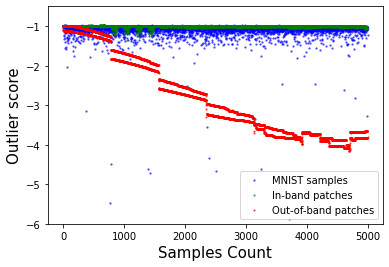

In [ ]:
# Plot the results
plt.figure(figsize=(6, 4))

# Plot the MNIST samples in blue
plt.scatter(np.arange(len(mnist_X)), mnist_scores, c='b', s=2, alpha=0.5, label='MNIST samples')

# Plot the malicious samples in red
plt.scatter(np.arange(len(mal_X)), mal_scores2, c='g', s=2, alpha=0.5, label='In-band patches')

# Plot the malicious samples in red
plt.scatter(np.arange(len(mal_X)), mal_scores1, c='r', s=2, alpha=0.5, label='Out-of-band patches')

#plt.title('Local Outlier Factor (LOF) on MNIST and Malicious images')
plt.xlabel('Samples Count',fontsize=15)
plt.ylabel('Outlier score',fontsize=15)

plt.ylim((-6,-.5))

plt.legend()
#plt.show()
plt.savefig("LOF_combined_Patches.png", bbox_inches='tight',dpi=300)